In [1]:
from tsai.all import *

/homes/sr339/anaconda3/envs/myenv/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning,


In [2]:
import sklearn.metrics as skm

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tsai.basics import *
import sktime
import sklearn
from tsai.models.MINIROCKET import *

In [6]:
from IPython.display import clear_output

In [7]:
data = np.load('z_score_schubert_dataset_all_avg_dev_features_seglen_200.npz')
#data = np.load('schubert_dataset_all_score_dev_features.npz')
#data = np.load('Robust_scaler_schubert_dataset_all_avgdev_features_seglen_200.npz')

In [8]:
X = data['name1']
y= data['name2']

In [9]:
X.shape

(414, 5, 200)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [12]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

In [13]:
torch.cuda.set_device(2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
device

device(type='cuda')

In [15]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[8, 8], batch_tfms=[TSStandardize()], num_workers=0)

In [18]:
xb, yb = dls.one_batch()

In [ ]:
len(dsets.train)

In [16]:
acc = []

epoch,train_loss,valid_loss,accuracy,time
0,2.123907,1.963611,0.385542,00:00
1,2.012005,1.770307,0.433735,00:00
2,1.916660,1.605426,0.530120,00:00
3,1.844477,1.476851,0.554217,00:00
4,1.761248,1.398500,0.542169,00:00
5,1.706854,1.275477,0.638554,00:00
6,1.643127,1.200638,0.686747,00:00
7,1.571027,1.149189,0.686747,00:00
8,1.532642,1.134282,0.638554,00:00
9,1.478622,1.144081,0.578313,00:00


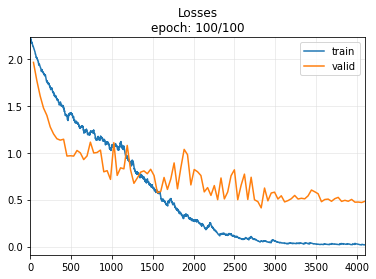

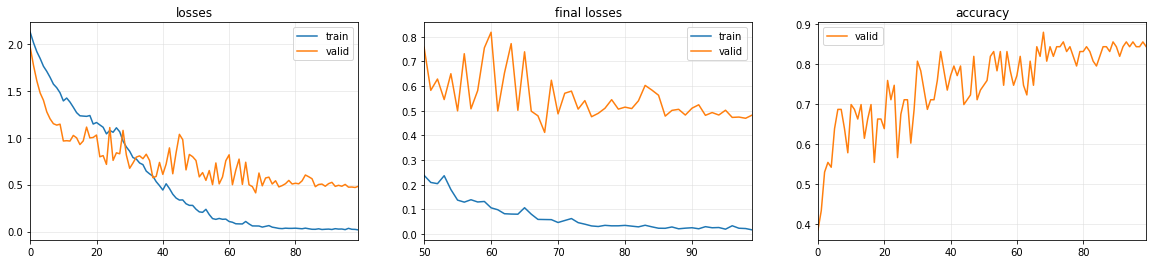

In [17]:
#model = create_model(FCN, dls=dls,**{'layers':[128, 256, 128], 'kss':[4, 4, 4]})
model = create_model(ResCNN, dls=dls)
learn = Learner(dls, model,  metrics=accuracy,cbs=ShowGraph())
start = time.time()
learn.fit_one_cycle(100, 1e-3)
elapsed = time.time() - start
vals = learn.recorder.values[-1]
acc.append(vals[2])

In [29]:
learn.

In [43]:
acc

[0.8433734774589539, 0.8072289228439331, 0.891566276550293]

In [35]:
learn.summary()

not enough values to plot a chart


FCN (Input shape: 8 x 5 x 200)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 200        
Conv1d                                    960        True      
BatchNorm1d                               128        True      
ReLU                                                           
Conv1d                                    16384      True      
BatchNorm1d                               128        True      
ReLU                                                           
Conv1d                                    16384      True      
BatchNorm1d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 1          
AdaptiveAvgPool1d                                              
____________________________________________________________________________
                     8 x 64

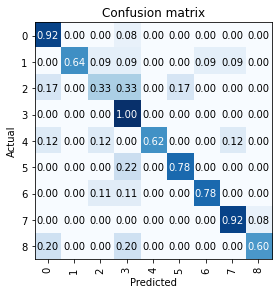

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

In [51]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       1.00      0.64      0.78        11
           2       0.40      0.33      0.36         6
           3       0.53      1.00      0.69         9
           4       1.00      0.62      0.77         8
           5       0.88      0.78      0.82         9
           6       0.88      0.78      0.82         9
           7       0.86      0.92      0.89        13
           8       0.75      0.60      0.67         5

    accuracy                           0.77        83
   macro avg       0.79      0.73      0.74        83
weighted avg       0.81      0.77      0.77        83



In [ ]:
#dls.show_batch(sharey=True)

In [ ]:
#model = build_ts_model(InceptionTimePlus, dls=dls)
#model = TST(dls.vars, dls.c, dls.len, dropout=.6, fc_dropout=.9)
model = build_ts_model(ResCNN, dls=dls)
# learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), 
#                 metrics= accuracy,  cbs=ShowGraphCallback2())
learn = Learner(dls, model, metrics=accuracy,cbs=ShowGraph())

In [ ]:
#learn = ts_learner(dls, metrics=accuracy)

In [ ]:
learn.lr_find()

In [ ]:
#learn = ts_learner(dls, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(100, lr_max=1e-3)
#learn.fit_one_cycle(100, 1e-3)

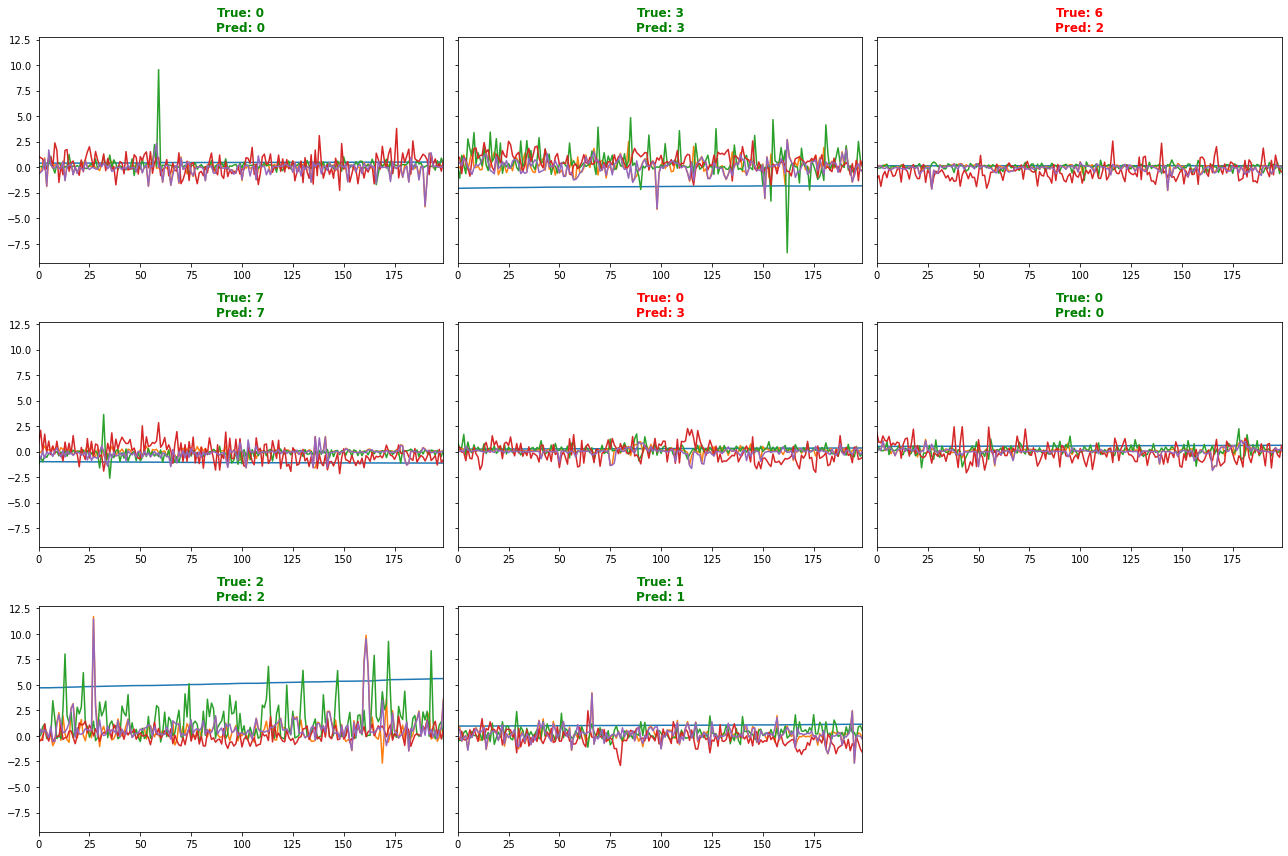

In [52]:
learn.show_results(sharey=True)

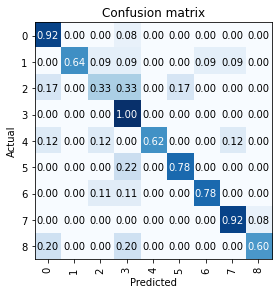

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

In [21]:
#### testing all models
bs = 8
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]

results = pd.DataFrame(columns=['model', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    print(k)
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(100, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)
     

{}
FCN


epoch,train_loss,valid_loss,accuracy,time
0,2.196756,2.197393,0.144578,00:00
1,2.150254,2.094170,0.265060,00:00
2,2.098275,1.967221,0.385542,00:00
3,2.044121,1.821450,0.385542,00:00
4,1.973608,1.766343,0.457831,00:00
5,1.900611,1.623877,0.445783,00:00
6,1.834772,1.548954,0.518072,00:00


KeyboardInterrupt: 

In [ ]:
results.to_csv('Robust_scaler_model_comparison_Schubert_dataset_avgdev_features.csv')

### Experiment with KNN

In [ ]:
from sklearn.pipeline import Pipeline

from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
#from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [ ]:
from sklearn.metrics import f1_score,precision_recall_fscore_support

In [ ]:
from sktime.datatypes._panel._convert import (
    from_3d_numpy_to_nested,
    from_multi_index_to_3d_numpy,
    from_nested_to_3d_numpy,
)

In [ ]:
X_nested = from_3d_numpy_to_nested(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_nested, y,test_size=0.2, random_state=42)

In [ ]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", KNeighborsTimeSeriesClassifier(n_neighbors=5, distance="euclidean")),
]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

In [ ]:
precision_recall_fscore_support(y_test, y_pred, average='macro')

In [ ]:
clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", KNeighborsTimeSeriesClassifier(n_neighbors=3, distance="dtw"), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
A = np.random.rand(3,4,20)

### using traditional sklearn

In [ ]:
X_new=X[:,3:5,:]

In [ ]:
X_new.shape

In [ ]:
X_new = X_new.reshape(-1, 400)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y,test_size=0.3, random_state=42)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=17).fit(X_train,y_train)
y_pred = clf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='macro')

In [ ]:
clf = svm.SVC(C=1,kernel='linear').fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='macro')

In [ ]:
acc = []
# Will take some time
from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [ ]:
from music21 import *

In [ ]:
%matplotlib inline

In [ ]:
paths = corpus.getComposer('chopin')

In [ ]:
paths

In [ ]:
midi = converter.parse('Sonate_No._14__Moonlight_short.mid')

In [ ]:
s2 = midi.parts.stream()

In [ ]:
vars(s2[0][0][0])

In [ ]:
for i in s2.parts.notesAndRests():
    print(i)

In [ ]:
for n in midi.flat.notes:
    print(n.pitch.name)

In [ ]:
verdi.measures(1, 1).plot('pianoroll')

In [ ]:
import pretty_midi
import numpy as np
# For plotting
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import pretty_midi as pm

In [ ]:
path = "/homes/sr339//Documents/Attention_network_calssification/ATEPP_ismir_performer_dataset/77_performance_dataset/train/Alfred Brendel/Beethoven/Piano_Sonata_No._3_in_C_Major,_Op._2_No._3/II._Adagio/39.mid"

In [ ]:
fl = pm.PrettyMIDI(path)

In [ ]:
result_array=fl.get_piano_roll()

In [ ]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch),cmap='gray_r')

In [ ]:
plt.figure(figsize=(12, 4))
ax = plt.axes()
plot_piano_roll(fl, 24, 84)
ax.set_facecolor("white")
plt.grid(which='both', axis='both', linestyle='--')

In [ ]:
fl.instruments[0].notes

In [ ]:
from mido import MidiFile

In [ ]:
midi_file = MidiFile('new_score.mid')

In [ ]:
for i, track in enumerate(midi_file.tracks):
    for message in track:
        print(message)